In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import configparser
import tensorflow as tf
import sys

from state_env import State
from RL_brain_pi_deep import DQNPrioritizedReplay


plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['blue', 'red', 'black', 'cyan', 'magenta', 'yellow', 'black'])

Instructions for updating:
non-resource variables are not supported in the long term
Seed used: 1760034950


# Comparison of single model using both methods

This notebook focuses on comparing a trained DRL model with the results obtained using the genetic algorithm method. 
In the following cell, one should specify the directory containing the GA solutions and the directory containing the trained DRL model.

In [2]:
# Define lists of directories for GA and DRL
# Example usage: fill these lists with the directories you want to compare
list_genetic_resulting_directories = [
    '../genetic_algorithm/results/reward_based_fitness_oaps_actions_95',
#    '../genetic_algorithm/results/original_functions',
]
ga_labels = ['(acc. Zhang)', '(original_func)']
list_trained_drl_directories = [
    '../adapted_zhang_implementation/modelos_exitosos/n16_25amp_25prob_optuna',
    '../adapted_zhang_implementation/modelos_exitosos/n16_10amp_10prob_opt',
]
rl_labels = ['DRL optimizado (p,a = 0.25) ', 'DRL optimizado (p,a = 0.10)']

# chain length (since ga directories include results for different chain lengths)
chain_length = 16
val_episodes = 80  # default, can be changed

ga_solutions_list = []
ga_config_instances = []
for genetic_resulting_directory in list_genetic_resulting_directories:
    ga_solutions_path = os.path.join(genetic_resulting_directory, f'n{chain_length}.txt')
    ga_solutions = np.loadtxt(ga_solutions_path)
    ga_solutions_list.append(ga_solutions)
    ga_ini_file = os.path.join(genetic_resulting_directory, f'n{chain_length}.ini')
    ga_config_instance = configparser.ConfigParser()
    ga_config_instance.read(ga_ini_file)
    ga_config_instances.append(ga_config_instance)

rl_best_solutions_list = []
rl_config_instances = []
rl_ini_paths = []
for trained_drl_directory in list_trained_drl_directories:
    ini_files = [f for f in os.listdir(trained_drl_directory) if f.endswith('.ini')]
    if not ini_files:
        raise FileNotFoundError(f"No .ini file found in {trained_drl_directory}")
    rl_ini_path = os.path.join(trained_drl_directory, ini_files[0])
    rl_ini_paths.append(rl_ini_path)
    rl_config_instance = configparser.ConfigParser()
    rl_config_instance.read(rl_ini_path)
    rl_config_instances.append(rl_config_instance)
    rl_best_solutions = np.loadtxt(os.path.join(trained_drl_directory, 'best_action_sequences.txt'))
    rl_best_solutions_list.append(rl_best_solutions)


### Fixed noise probability (variable amplitude)

In [ ]:
noise_steps = 10
noise_amplitude_values = np.linspace(0, 0.25, noise_steps)
fixed_probability_value = 0.5
fs = 14
plt.figure(figsize=(6, 5))

# DRL comparison for each directory
for idx, (rl_config_instance, trained_drl_directory, rl_label) in enumerate(zip(rl_config_instances, list_trained_drl_directories, rl_labels)):
    mean_fids = []
    std_fids = []
    for noise_amplitude in noise_amplitude_values:
        tf.compat.v1.reset_default_graph()
        if not rl_config_instance.has_section('noise_parameters'):
            rl_config_instance.add_section('noise_parameters')
        rl_config_instance.set('noise_parameters', 'noise', 'True')
        rl_config_instance.set('noise_parameters', 'noise_amplitude', str(noise_amplitude))
        rl_config_instance.set('noise_parameters', 'noise_probability', str(fixed_probability_value))
        with tf.compat.v1.Session() as sess:
            RL_val = DQNPrioritizedReplay(config_instance=rl_config_instance, sess=sess)
            saver = tf.compat.v1.train.Saver()
            checkpoint_path = os.path.join(trained_drl_directory, 'best_model', 'model.ckpt')
            saver.restore(sess, checkpoint_path)
            env = State(config_instance=rl_config_instance)
            max_t_steps = rl_config_instance.getint('system_parameters', 'max_t_steps')
            max_fids = []
            for episode in range(val_episodes):
                observation = env.reset()
                fid_max = 0
                for i in range(max_t_steps):
                    action = RL_val.choose_action(observation, eval=True)
                    observation_, reward, fidelity = env.step(action)
                    observation = observation_.copy()
                    if fidelity > fid_max:
                        fid_max = fidelity
                max_fids.append(fid_max)
            mean_fids.append(np.mean(max_fids))
            std_fids.append(np.std(max_fids))
    plt.errorbar(noise_amplitude_values, mean_fids, yerr=std_fids, marker='o', label=f'{rl_label}', capsize=4)

# GA comparison for each directory
def ga_sweep(ga_solutions, ga_config_instance):
    mean_fids = []
    std_fids = []
    for noise_amplitude in noise_amplitude_values:
        if not ga_config_instance.has_section('noise_parameters'):
            ga_config_instance.add_section('noise_parameters')
        ga_config_instance.set('noise_parameters', 'noise', 'True')
        ga_config_instance.set('noise_parameters', 'noise_amplitude', str(noise_amplitude))
        ga_config_instance.set('noise_parameters', 'noise_probability', str(fixed_probability_value))
        env = State(config_instance=ga_config_instance)
        max_t_steps = ga_config_instance.getint('system_parameters', 'max_t_steps')
        max_fids = []
        for ga_solution in range(np.shape(ga_solutions)[0]):
            observation = env.reset()
            fid_max = 0
            for i in range(max_t_steps):
                action = int(ga_solutions[ga_solution, i])
                observation_, reward, fidelity = env.step(action)
                observation = observation_.copy()
                if fidelity > fid_max:
                    fid_max = fidelity
            max_fids.append(fid_max)
        mean_fids.append(np.mean(max_fids))
        std_fids.append(np.std(max_fids))
    return mean_fids, std_fids

for idx, (ga_solutions, ga_config_instance, ga_label) in enumerate(zip(ga_solutions_list, rl_config_instances, ga_labels)):
    mean_fids, std_fids = ga_sweep(ga_solutions, ga_config_instance)
    plt.errorbar(noise_amplitude_values, mean_fids, yerr=std_fids, marker='x', label=f'GA {ga_label}', capsize=4)

plt.xlabel('Noise Amplitude [a]', fontsize=fs)
#plt.title(f'Mean Max Fidelity vs Noise Amplitude (Probability={fixed_probability_value})', fontsize=fs)
plt.ylabel('Fidelidad Media [P]', fontsize=fs)
plt.legend(fontsize=fs)
plt.grid(True)
plt.show()


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
INFO:tensorflow:Restoring parameters from ../adapted_zhang_implementation/modelos_exitosos/n16_25amp_25prob_optuna/best_model/model.ckpt


2025-10-09 15:35:50.174827: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 3693155000 Hz
2025-10-09 15:35:50.175373: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5bdc35778960 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2025-10-09 15:35:50.175437: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


INFO:tensorflow:Restoring parameters from ../adapted_zhang_implementation/modelos_exitosos/n16_25amp_25prob_optuna/best_model/model.ckpt
INFO:tensorflow:Restoring parameters from ../adapted_zhang_implementation/modelos_exitosos/n16_25amp_25prob_optuna/best_model/model.ckpt
INFO:tensorflow:Restoring parameters from ../adapted_zhang_implementation/modelos_exitosos/n16_25amp_25prob_optuna/best_model/model.ckpt
INFO:tensorflow:Restoring parameters from ../adapted_zhang_implementation/modelos_exitosos/n16_25amp_25prob_optuna/best_model/model.ckpt
INFO:tensorflow:Restoring parameters from ../adapted_zhang_implementation/modelos_exitosos/n16_25amp_25prob_optuna/best_model/model.ckpt
INFO:tensorflow:Restoring parameters from ../adapted_zhang_implementation/modelos_exitosos/n16_25amp_25prob_optuna/best_model/model.ckpt
INFO:tensorflow:Restoring parameters from ../adapted_zhang_implementation/modelos_exitosos/n16_25amp_25prob_optuna/best_model/model.ckpt


Fixed noise amplitude (variable probability)

INFO:tensorflow:Restoring parameters from ../adapted_zhang_implementation/modelos_exitosos/n16_25amp_25prob_optuna/best_model/model.ckpt
INFO:tensorflow:Restoring parameters from ../adapted_zhang_implementation/modelos_exitosos/n16_25amp_25prob_optuna/best_model/model.ckpt
INFO:tensorflow:Restoring parameters from ../adapted_zhang_implementation/modelos_exitosos/n16_25amp_25prob_optuna/best_model/model.ckpt
INFO:tensorflow:Restoring parameters from ../adapted_zhang_implementation/modelos_exitosos/n16_25amp_25prob_optuna/best_model/model.ckpt
INFO:tensorflow:Restoring parameters from ../adapted_zhang_implementation/modelos_exitosos/n16_25amp_25prob_optuna/best_model/model.ckpt
INFO:tensorflow:Restoring parameters from ../adapted_zhang_implementation/modelos_exitosos/n16_25amp_25prob_optuna/best_model/model.ckpt
INFO:tensorflow:Restoring parameters from ../adapted_zhang_implementation/modelos_exitosos/n16_25amp_25prob_optuna/best_model/model.ckpt
INFO:tensorflow:Restoring parameters from

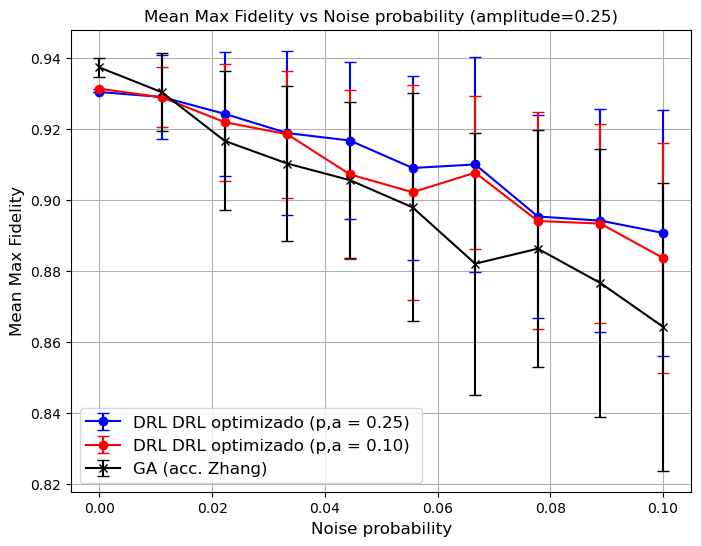

In [ ]:
noise_steps = 10
noise_probability_values = np.linspace(0, 0.1, noise_steps)
fixed_amplitude_value = 0.25
fs = 12
plt.figure(figsize=(8, 6))

# DRL comparison for each directory
for idx, (rl_config_instance, trained_drl_directory, rl_labels) in enumerate(zip(rl_config_instances, list_trained_drl_directories, rl_labels)):
    mean_fids = []
    std_fids = []
    for noise_probability in noise_probability_values:
        tf.compat.v1.reset_default_graph()
        if not rl_config_instance.has_section('noise_parameters'):
            rl_config_instance.add_section('noise_parameters')
        rl_config_instance.set('noise_parameters', 'noise', 'True')
        rl_config_instance.set('noise_parameters', 'noise_probability', str(noise_probability))
        rl_config_instance.set('noise_parameters', 'noise_amplitude', str(fixed_amplitude_value))
        with tf.compat.v1.Session() as sess:
            RL_val = DQNPrioritizedReplay(config_instance=rl_config_instance, sess=sess)
            saver = tf.compat.v1.train.Saver()
            checkpoint_path = os.path.join(trained_drl_directory, 'best_model', 'model.ckpt')
            saver.restore(sess, checkpoint_path)
            env = State(config_instance=rl_config_instance)
            max_t_steps = rl_config_instance.getint('system_parameters', 'max_t_steps')
            max_fids = []
            for episode in range(val_episodes):
                observation = env.reset()
                fid_max = 0
                for i in range(max_t_steps):
                    action = RL_val.choose_action(observation, eval=True)
                    observation_, reward, fidelity = env.step(action)
                    observation = observation_.copy()
                    if fidelity > fid_max:
                        fid_max = fidelity
                max_fids.append(fid_max)
            mean_fids.append(np.mean(max_fids))
            std_fids.append(np.std(max_fids))
    plt.errorbar(noise_probability_values, mean_fids, yerr=std_fids, marker='o', label=f'DRL {rl_labels}', capsize=4)

# GA comparison for each directory
for idx, (ga_solutions, ga_config_instance, ga_label) in enumerate(zip(ga_solutions_list, ga_config_instances, ga_labels)):
    mean_fids = []
    std_fids = []
    for noise_probability in noise_probability_values:
        
        if not ga_config_instance.has_section('noise_parameters'):
            ga_config_instance.add_section('noise_parameters')
            
        ga_config_instance.set('noise_parameters', 'noise', 'True')
        ga_config_instance.set('noise_parameters', 'noise_probability', str(noise_probability))
        ga_config_instance.set('noise_parameters', 'noise_amplitude', str(fixed_amplitude_value))
        env = State(config_instance=ga_config_instance)
        max_t_steps = ga_config_instance.getint('system_parameters', 'max_t_steps')
        max_fids = []
        for ga_solution in range(np.shape(ga_solutions)[0]):
            observation = env.reset()
            fid_max = 0
            for i in range(max_t_steps):
                action = int(ga_solutions[ga_solution, i])
                observation_, reward, fidelity = env.step(action)
                observation = observation_.copy()
                if fidelity > fid_max:
                    fid_max = fidelity
            max_fids.append(fid_max)
        mean_fids.append(np.mean(max_fids))
        std_fids.append(np.std(max_fids))
    plt.errorbar(noise_probability_values, mean_fids, yerr=std_fids, marker='x', label=f'GA {ga_label}', capsize=4)

plt.xlabel('Noise probability', fontsize=fs)
plt.title(f'Mean Max Fidelity vs Noise probability (amplitude={fixed_amplitude_value})', fontsize=fs)
plt.ylabel('Mean Max Fidelity', fontsize=fs)
plt.legend(fontsize=fs)
plt.grid(True)
plt.show()


In [ ]:
def fid_evolution(sequence, env, add_natural=False):
    
    fidelity_evolution = []
    observation = env.reset()
    fid_max = 0
    
    for action in sequence:
        action = int(action)
        observation_, reward, fidelity = env.step(action)
        observation = observation_.copy()
        fidelity_evolution.append(fidelity)

    natural_evolution = None
    if add_natural:
        natural_evolution = []
        observation = env.reset()
        for _ in sequence:
            observation_, reward, fidelity = env.step(0)
            observation = observation_.copy()
            natural_evolution.append(fidelity)
            
    return fidelity_evolution, natural_evolution

In [ ]:
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

plt.figure(figsize=(8, 6))
samples = np.arange(10)
fs = 12

# Store the last natural_evol for plotting outside the loop
last_natural_evol = None

# Plot GA samples for each directory
for idx, (ga_solutions, ga_config_instance) in enumerate(zip(ga_solutions_list, ga_config_instances)):
    for sample in samples:
        env = State(config_instance=ga_config_instance)
        forced_evol, natural_evol = fid_evolution(ga_solutions[sample][:], env, add_natural=True)
        plt.plot(forced_evol, '-o', label=f'GA {idx+1} sample {sample}', color='red', alpha=0.3, linewidth=1.2, markersize=0.2)
        last_natural_evol = natural_evol  # Save the last one for plotting

# Plot DRL samples for each directory
for idx, (rl_best_solutions, rl_config_instance) in enumerate(zip(rl_best_solutions_list, rl_config_instances)):
    for sample in samples:
        env = State(config_instance=rl_config_instance)
        forced_evol, natural_evol = fid_evolution(rl_best_solutions[sample][:], env, add_natural=True)
        plt.plot(forced_evol, '-o', label=f'DRL {idx+1} sample {sample}', color='blue', alpha=0.3, linewidth=1.2, markersize=0.2)

if last_natural_evol is not None:
    plt.plot(last_natural_evol, '-o', label='Natural', color='green', alpha=0.5, linewidth=5, markersize=0.2, zorder=-2)

plt.xlabel('Paso Temporal / Cantidad de pulsos', fontsize=fs)
plt.ylabel('Fidelidad', fontsize=fs)

legend_elements = [
    Line2D([0], [0], color='red', lw=1.2, label='GA'),
    Line2D([0], [0], color='blue', lw=1.2, label='DRL'),
    Line2D([0], [0], color='green', lw=1.5, label='Natural')
]
plt.legend(handles=legend_elements, fontsize=fs, loc='lower left', bbox_to_anchor=(0, 0.1))
plt.text(0.02, 0.09, '(b)', transform=plt.gca().transAxes, fontsize=fs, verticalalignment='top', horizontalalignment='left', bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
plt.title(f'Probabilidades de transición para N={chain_length}', fontsize=fs)

# Agregar inset
ax_inset = inset_axes(plt.gca(), width="40%", height="50%", loc="upper left")
if last_natural_evol is not None:
    ax_inset.plot(range(len(last_natural_evol))[int(-2.5*chain_length):], last_natural_evol[int(-2.5*chain_length):], '-o', label='Natural', color='green', alpha=0.5, linewidth=5, markersize=0.2, zorder=-2)
for idx, (ga_solutions, ga_config_instance) in enumerate(zip(ga_solutions_list, ga_config_instances)):
    for sample in samples:
        env = State(config_instance=ga_config_instance)
        forced_evol, _ = fid_evolution(ga_solutions[sample][:], env, add_natural=False)
        ax_inset.plot(range(len(forced_evol))[int(-2.5*chain_length):], forced_evol[int(-2.5*chain_length):], '-o', color='red', alpha=0.3, linewidth=1.2, markersize=0.2)
for idx, (rl_best_solutions, rl_config_instance) in enumerate(zip(rl_best_solutions_list, rl_config_instances)):
    for sample in samples:
        env = State(config_instance=rl_config_instance)
        forced_evol, _ = fid_evolution(rl_best_solutions[sample][:], env, add_natural=False)
        ax_inset.plot(range(len(forced_evol))[int(-2.5*chain_length):], forced_evol[int(-2.5*chain_length):], '-o', color='blue', alpha=0.3, linewidth=1.2, markersize=0.2)
ax_inset.yaxis.tick_right()
ax_inset.tick_params(axis='both', which='major', labelsize=fs - 6)
ax_inset.set_yticks([0., 0.5, 0.95])
ax_inset.tick_params(axis='x', labelsize=fs - 6)
ax_inset.tick_params(axis='y', labelsize=fs - 6)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.tight_layout(pad=6.0)


NoSectionError: No section: 'learning_parameters'

<Figure size 800x600 with 0 Axes>